In [1]:
%load_ext autoreload
%autoreload 2

import argparse

import sys
import numpy as np
from scipy.io import loadmat, savemat
from copy import deepcopy

sys.path.append('../utils/preprocessing/')
sys.path.append('../utils/recalibration/')
sys.path.append('../utils/plotting/')
from hmm_utils import HMM_estimate
from plotting_utils import figSize
from sklearn.linear_model import LinearRegression
#from hmm_utils import get_DiscreteTargetGrid

def loadCompressedSession(file):
    '''Loads and gets recent block/session data ready for HMM. Inputs are:
    
        file (str) - path to compressed R_Struct (this is output of processBlocks.m)
        
    TODO: cut out time prior to first trial to avoid non-BCI control timebins'''
    
    dat = loadmat(file, simplify_cells = True)['compressed']
    
    dat['TX'] = dat['TX'].astype('float64')
    
    for block in dat['blockList']:
        blockMean                                = dat['TX'][dat['blockNums'] == block, :].mean(axis = 0)
        dat['TX'][dat['blockNums'] == block, :] -=  blockMean
        
    return dat

def get_CompressedDiscreteTargetGrid(compressed_session, gridSize):
    '''Return discretized BCI cursor screen locations for compressed block data.
       Inputs are:
       
           compressed_session (dict) - block/session data to use
           gridSize (int)            - grid width/height; total states = gridSize**2
    
    '''
    targpos_data  = compressed_session['targetPos']
    
    X_min, X_max  = targpos_data[:, 0].min() - 20, targpos_data[:, 0].max() + 20
    Y_min, Y_max  = targpos_data[:, 1].min() - 20, targpos_data[:, 1].max() + 20

    X_loc,Y_loc   = np.meshgrid(np.linspace(X_min, X_max, gridSize), np.linspace(Y_min, Y_max, gridSize))
    targLocs      = np.vstack([np.ravel(X_loc), np.ravel(Y_loc[:])]).T
    
    return targLocs

def adjustKappa(dist):
    coef = 1 / (1 + np.exp(-1 * (dist - 70) * 0.5))
    return coef 

In [3]:
file = 'D:/T5_ClosedLoop/t5.2021.05.17_compressed.mat'

gridSize      = 20  
stayProb      = 0.9999
vmKappa       = 2
probThreshold = 'probWeighted'

#---------------------------------------------

data          = loadCompressedSession(file)
targLocs      = get_CompressedDiscreteTargetGrid(data, gridSize = gridSize)
nStates       = gridSize**2
stateTrans    = np.eye(nStates)*stayProb #Define the state transition matrix, which assumes uniform transition probability of transitioning to new state

for x in range(nStates):
    idx                = np.setdiff1d(np.arange(nStates), x)
    stateTrans[x, idx] = (1-stayProb)/(nStates-1)
    
pStateStart = np.zeros((nStates,1)) + (1/nStates)

    


targStates, pTargState = HMM_estimate([data['decVel']], [data['cursorPos']], stateTrans, pStateStart, targLocs, vmKappa, adjustKappa)

maxProb         = np.max(pTargState, axis = 0)              
inferredTargLoc = targLocs[targStates.astype('int').flatten(), :]    # find predicted target locations for high prob times
inferredPosErr  = inferredTargLoc - data['cursorPos']                # generate inferred cursorErr signals

# TODO - align this with standard CL recal settings:
VKF = LinearRegression(normalize = False).fit(data['TX'], inferredPosErr, maxProb**2)


weights = VKF.coef_ 
saveDir = './'
savemat(saveDir + 'weights', {'weights' : weights})

In [9]:
dat = loadmat(file, simplify_cells = True)['compressed']

dat['blockList']

array([2, 3, 4], dtype=uint8)

In [100]:
weights = VKF.coef_ 
savemat(saveDir + 'weights', {'weights' : weights})

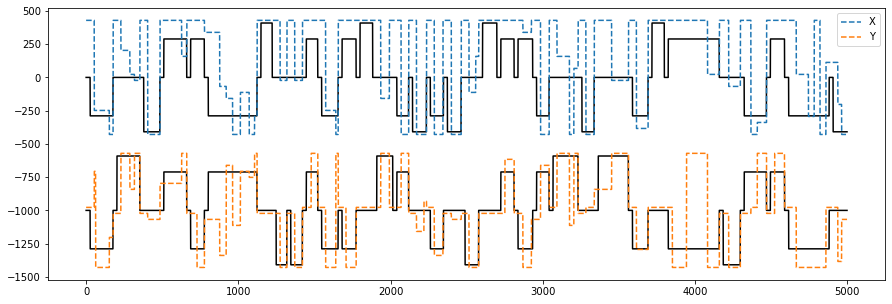

In [5]:
import matplotlib.pyplot as plt 

figSize(5, 15)
labels = ['X', 'Y']

for i in range(2):
    plt.plot(data['targetPos'][:5000, i] - (i * 1000), color = 'k')
    plt.plot(inferredTargLoc[:5000, i] - (i * 1000), linestyle = '--', label = labels[i])
plt.legend()

In [97]:
VKF.coef_

(2, 192)